# Formation and refinement of cells during plastic deformation
This is a notebook made for the data analysis presented in the paper "Formation and refinement of cells during plastic deformation" by Zelenika et al. It aims to provide an overview to the reader of the necessary data analysis and the underlying logic used to produces the results and plots shown in the article. This notebook follows the layout seen in the supplimentary materials of the paper. 

The various cells should provide the reader with the ability to remake all the figures shown in the paper as well as potentially manipulate the data. This Notebook has the goal of bringing these large datasets and the resulting data analysis to a large audience of material scientists and physicist who may not be used to working with the rich datasets produced by synchrotron experiments. It is the hope of the authors that this endeavour will lead to increased interest, trust and data analysis pipelines for Dark-Field X-ray Microscopy studies. 

# Import all the necessary packages 
This note book should be run in an adequate kernel with the necessary dependencies. The git repository hosting this notebook contains such a kernel titled "matlab" as part of this code is a direct translation of a legacy matlab scripts written by Henning Friis Poulsen. 

In [89]:
import fabio
from matplotlib.widgets import Slider
import numpy as np
from skimage.morphology import binary_erosion, binary_dilation, disk, skeletonize, remove_small_objects, binary_opening, dilation
from scipy.ndimage import label
from skimage.feature import canny
from skimage.measure import regionprops
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from scipy.stats import norm, lognorm, rayleigh, chi, maxwell
from scipy.optimize import curve_fit
from rtree import index
import time 
import csv
import os

# Import the data 

Set the pixel size, find the file names and initialise the necessary lists

In [90]:
path = 'C:\\Users\\adacre\\OneDrive - Danmarks Tekniske Universitet\\Documents\\DTU_Project\\data\\fit15\\'
files = [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]
com_phi = [file for file in files if 'com_phi' in file]
com_chi =[file for file in files if 'com_chi' in file]
fwhm_phi = [file for file in files if 'fwhm_phi' in file]
fwhm_chi = [file for file in files if 'fwhm_chi' in file]

def extract_number(filename):
    u_index = filename.find('u')
    substring = filename[:u_index] if u_index != -1 else filename
    return int(''.join(filter(str.isdigit, substring)))

com_phi = sorted(com_phi, key=extract_number)
com_chi = sorted(com_chi, key=extract_number)
fwhm_chi = sorted(fwhm_chi, key=extract_number)
fwhm_phi = sorted(fwhm_phi, key=extract_number)

# Extract the file numbers
names = [extract_number(file) for file in com_phi]
# Information about pixel size
pixel_y = 0.203; pixel_x = 0.6575; # effective pixel sizes in mu

# Get the strain steps for plot titles
strain = [0.005, 0.008, 0.013, 0.024, 0.035, 0.046]

# Print the file numbers
print(names)

# Define the lists
av_cell, av_cell1 = [], []
sizes, sizes1 = [], []
X, X1 = [], []
PDF, PDF1 = [], []
excel_data = {}
mean_sizes = []
filtered_cell_counts = []
area_sizes, area_sizes1 = [], []
cell_density = []
v_fraction = []
cell_number = []
major_axes = []
minor_axes = []
orientations = []


[88, 138, 238, 438, 638, 838]


# KAM calculation
Apply the KAM to all the data sets, find the grain sizes and creates mosaicity images for all samples 

In [91]:
KAMs = []
Mosa_Imgs = []
grain_sizes = []
grain_masks = [] 
# Loop over all samples
for i in range(len(com_chi)):
    chi_file = fabio.open(path + com_chi[i])
    A = chi_file.data
    row_size, col_size = A.shape
    B = np.flipud(A.T)
    TF = np.isnan(B)
    ave_chi = np.nanmean(A)
    Chi_Img = B - ave_chi

    phi_file = fabio.open(path + com_phi[i])
    A = phi_file.data
    B1 = np.flipud(A.T)
    TF = np.isnan(B)
    ave_phi = np.nanmean(A)  # Compute the average, ignoring NaNs
    Phi_Img = B1 - ave_phi
    max_phi = np.nanmax(Phi_Img)  # Find max, ignoring NaNs
    max_chi = np.nanmax(Chi_Img)  # Find max, ignoring NaNs

    # Assuming TF is a binary numpy array
    grain1 = ~TF
    se = disk(3, strict_radius=True)  # Create a disk-shaped structuring element with radius 3

    # Perform erosion and dilation
    grain1 = binary_erosion(binary_erosion(grain1, se), se)
    grain_mask = binary_dilation(binary_dilation(grain1, se), se)
    grain_masks.append(grain_mask)

    # Calculate the area of the grain mask
    grain_mask_area = np.sum(grain_mask) * pixel_x * pixel_y
    grain_sizes.append(grain_mask_area)

    # Set pixels outside the mask to slightly above max values
    Chi_Img[~grain_mask] = max_chi * 1.8
    Phi_Img[~grain_mask] = max_phi * 1.8

    # Scale Chi_Img and Phi_Img
    MinChi, MaxChi = np.nanmin(Chi_Img), np.nanmax(Chi_Img)
    Chi_scale = (Chi_Img - MinChi) / (MaxChi - MinChi)
    MinPhi, MaxPhi = np.nanmin(Phi_Img), np.nanmax(Phi_Img)
    Phi_scale = (Phi_Img - MinPhi) / (MaxPhi - MinPhi)

    # Create RGB image Mosa_Img and add to Mosa_Imgs list
    Mosa_Img = np.stack((Chi_scale, Phi_scale, np.ones_like(Chi_scale)), axis=-1)
    Mosa_Imgs.append(Mosa_Img)

    kernelSize = 2
    KAM = np.zeros((col_size, row_size))

    # Loop over all data points
    for ii in range(col_size):
        for jj in range(row_size):
            if grain_mask[ii, jj] == 1:
                # Define the kernel boundaries
                iStart = max(ii - kernelSize, 0)
                iEnd = min(ii + kernelSize, col_size - 1)
                jStart = max(jj - kernelSize, 0)
                jEnd = min(jj + kernelSize, row_size - 1)

                # Calculate the kernel difference
                kernel_diff = np.abs(Chi_Img[iStart:iEnd+1, jStart:jEnd+1] - Chi_Img[ii, jj]) + \
                            np.abs(Phi_Img[iStart:iEnd+1, jStart:jEnd+1] - Phi_Img[ii, jj])
                nr_pixels_ROI = (iEnd - iStart + 1) * (jEnd - jStart + 1)

                # Store the average misorientation angle in the KAM map
                KAM[ii, jj] = np.sum(kernel_diff) / nr_pixels_ROI

    KAMs.append(KAM)
print('Done with KAMs')
print("Grain sizes:", grain_sizes)
print("# of Grain masks:", len(grain_masks))

Done with KAMs
Grain sizes: [171647.63708749998, 170272.33644749998, 168527.18351, 163604.984655, 155378.807535, 131861.3534525]
# of Grain masks: 6


# Cell count, sizes and density
The first cell process the data and extracts the necessary variables, the second cell is used to calculate and plot the relevant information

In [92]:
filtered_cell_counts = []
cell_density = []
v_fraction = []
sizes = []
sizes1 = []
areas_all = []
areas_all1 = []

# Loop through each KAM in KAMs
for _ in range(len(KAMs)):
    KAM_list = np.arange(0, 0.085, 0.001).tolist()
    for value in KAM_list:
        KAM_threshold = value
        KAM_filter = np.zeros_like(KAMs[_], dtype=bool)
        KAM_filter[grain_masks[_] & (KAMs[_] > KAM_threshold)] = True

        area_ratio = np.sum(KAM_filter) / np.sum(grain_masks[_])
        
        if 0.69 < area_ratio < 0.72 or area_ratio < 0.65:
            if area_ratio < 0.65:
                KAM_threshold = 0.015
                KAM_filter = np.zeros_like(KAMs[_], dtype=bool)
                KAM_filter[grain_masks[_] & (KAMs[_] > KAM_threshold)] = True

            se = disk(1)
            KAM2 = binary_erosion(KAM_filter, se)
            KAM_mask = binary_dilation(KAM2, se)
            skel_Img = skeletonize(KAM_mask)


            BW_img = ~binary_dilation(skel_Img, disk(1))
            WB_img = ~BW_img
            mask_pixels = np.sum(WB_img) * pixel_x * pixel_y
            grain_size = grain_sizes[_] - mask_pixels

            labeled_array, num_features = label(BW_img)
            nr_cells = num_features
            props = regionprops(labeled_array)
            min_cell_size = 10

            # Make a copy and handle NaN and value ranges
            mosa = Mosa_Imgs[_].copy()
            mosa[np.isnan(mosa)] = 0  # Set NaNs to 0
            mosa[mosa < 0] = 0        # Clamp values below 0 to 0
            mosa[mosa > 1] = 1        # Clamp values above 1 to 1

            # Create a mask of the grain taking into account holes from missing data
            mask = np.all(mosa == [1, 1, 1], axis=-1)

            # Dilate the mask to also exclude the neighbors
            erroded_mask = binary_erosion(mask, disk(3))
            dilated_mask = binary_erosion(erroded_mask, disk(3))
            dilated_mask = binary_dilation(dilated_mask, disk(3))
            dilated_mask = binary_dilation(dilated_mask, disk(20))
            
             # List to store the properties of regions that do not overlap with the mask
            filtered = []
            filtered_props = []

            # Iterate over each region in props
            for region in props:
                # Get the coordinates of the region
                region_coords = region.coords

                # Check if any of the coordinates overlap with the mask
                overlap = np.any(erroded_mask[region_coords[:, 0], region_coords[:, 1]])

                # If there is no overlap and the region meets the size criteria, add it to the list
                if not overlap and region.area >= min_cell_size:
                    filtered_props.append(region)
            
            # Filter out regions that are too large
            filtered_props = [prop for prop in filtered_props if prop.area * pixel_x * pixel_y <= 500]

            print("Filtered Cell Counts:", len(filtered_props))
            # Calculate the number of cells per unit area
            nr_cells_per_unit_area = len(filtered_props) / grain_size

            # Calculate areas and centroids
            areas = [prop.area * pixel_x * pixel_y for prop in props]
            areas_filtered = [prop.area * pixel_x * pixel_y for prop in filtered_props]
            areas_all.append(areas)
            areas_all1.append(areas_filtered)

            # Calculate volume fraction of cells
            v_fraction.append(np.sum(areas_filtered) / grain_size)

            # Size from area calculations
            size_from_area = np.sqrt(areas)
            size_from_area_filtered = np.sqrt(areas_filtered)

    print("Filtered Cell Counts:", len(filtered_props))
    # Append the lists cell density is the density of cells in each sample, sizes contains the size of each cell in each sample       
    cell_density.append(nr_cells_per_unit_area)
    sizes.append(size_from_area)
    sizes1.append(size_from_area_filtered)

# Print or return the lists as required
print("Cell Density:", cell_density)
print("Sizes:", sizes)
print("Filtered Sizes:", sizes1)

Filtered Cell Counts: 45
Filtered Cell Counts: 45
Filtered Cell Counts: 45
Filtered Cell Counts: 45
Filtered Cell Counts: 45
Filtered Cell Counts: 45
Filtered Cell Counts: 45
Filtered Cell Counts: 45
Filtered Cell Counts: 45
Filtered Cell Counts: 45
Filtered Cell Counts: 45
Filtered Cell Counts: 45
Filtered Cell Counts: 45
Filtered Cell Counts: 45
Filtered Cell Counts: 45
Filtered Cell Counts: 45
Filtered Cell Counts: 45
Filtered Cell Counts: 45
Filtered Cell Counts: 45
Filtered Cell Counts: 45
Filtered Cell Counts: 45
Filtered Cell Counts: 45
Filtered Cell Counts: 45
Filtered Cell Counts: 45
Filtered Cell Counts: 45
Filtered Cell Counts: 45
Filtered Cell Counts: 45
Filtered Cell Counts: 45
Filtered Cell Counts: 45
Filtered Cell Counts: 45
Filtered Cell Counts: 45
Filtered Cell Counts: 45
Filtered Cell Counts: 45
Filtered Cell Counts: 45
Filtered Cell Counts: 45
Filtered Cell Counts: 45
Filtered Cell Counts: 45
Filtered Cell Counts: 45
Filtered Cell Counts: 45
Filtered Cell Counts: 45


The following cell is used to calculate the nomalised number of cells, the volume fraction of cells and the mean cell size at each deformation step.

Cell Density: [46.02491933604639, 100.38823962218243, 1703.2948776152557, 6751.87053551117, 5934.338668417498, 5865.4432304506745]


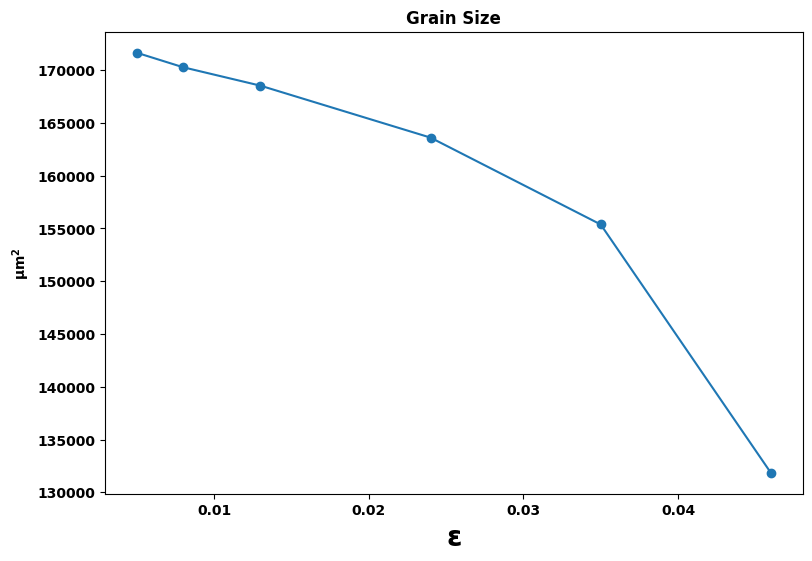

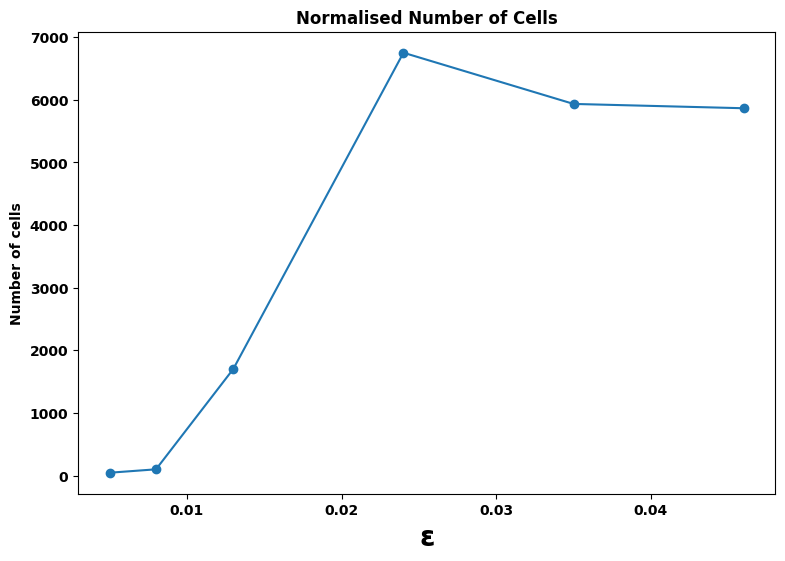

ValueError: x and y must have same first dimension, but have shapes (6,) and (378,)

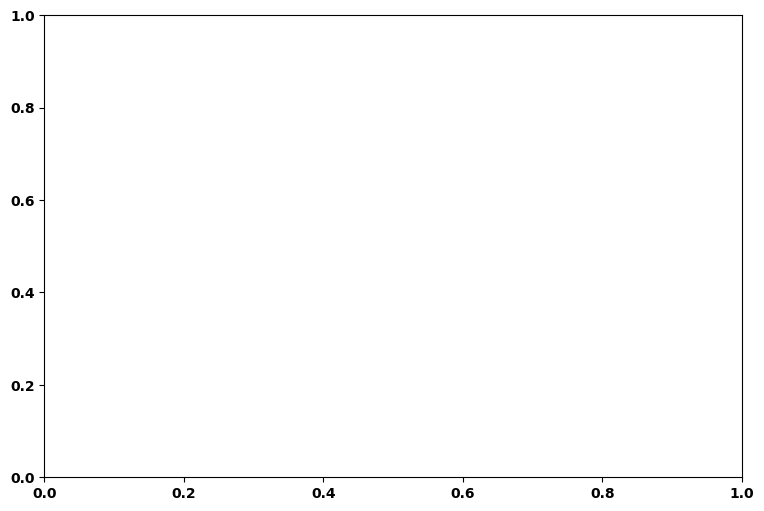

In [88]:
for i in range(len(cell_density)):
    cell_density[i] = cell_density[i] * grain_sizes[0]

print("Cell Density:", cell_density)
plt.figure(figsize=(9, 6))
plt.plot(strain, grain_sizes, 'o-')
plt.xlabel('$\epsilon$', fontsize=20)
plt.ylabel('$\mu m^2$')
plt.title('Grain Size')
plt.show()

# Plotting number of cells
plt.figure(figsize=(9, 6))
plt.plot(strain, cell_density, 'o-', label='Number of Cells normalised per area')
plt.xlabel('$\epsilon$', fontsize=20)
plt.ylabel('Number of cells')
plt.title('Normalised Number of Cells')
plt.show()

# Plotting volume fraction of cells
plt.figure(figsize=(9, 6))
plt.plot(strain, v_fraction, 'o-', label='Volume Fraction of Cells')
plt.xlabel('$\epsilon$', fontsize=20)
plt.ylabel('Volume Fraction')
plt.title('Volume Fraction of Cells')
plt.show()